In [14]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import pandas as pd
import warnings
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import numpy as np
from sklearn.model_selection import train_test_split

# Ignore all warnings (not recommended)
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [15]:
accident_data = pd.read_csv("cleaned.csv") 

In [16]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age_band_of_driver       12316 non-null  object
 1   Sex_of_driver            12316 non-null  object
 2   Educational_level        12316 non-null  object
 3   Vehicle_driver_relation  12316 non-null  object
 4   Driving_experience       12316 non-null  object
 5   Lanes_or_Medians         12316 non-null  object
 6   Types_of_Junction        12316 non-null  object
 7   Road_surface_type        12316 non-null  object
 8   Light_conditions         12316 non-null  object
 9   Weather_conditions       12316 non-null  object
 10  Type_of_collision        12316 non-null  object
 11  Vehicle_movement         12316 non-null  object
 12  Pedestrian_movement      12316 non-null  object
 13  Cause_of_accident        12316 non-null  object
 14  Accident_severity        12316 non-nul

In [17]:
cat_columns = [colname for colname in accident_data.select_dtypes(["object", "category"])]
len(cat_columns)

14

In [18]:
# describe categorical columns
accident_data.describe(include='object')

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident
count,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316
unique,5,3,7,4,8,7,8,6,4,9,10,13,9,20
top,18-30,Male,Junior high school,Employee,5-10yr,Two-way (divided with broken lines road marking),Y Shape,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,No distancing
freq,4271,11437,7619,9627,3363,4411,4543,11296,8798,10063,8774,8158,11390,2263


In [19]:
accident_data.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
0,18-30,Male,Above high school,Employee,1-2yr,Unknown,No junction,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Not a Pedestrian,Moving Backward,2
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2


In [20]:
pip install dabl

Note: you may need to restart the kernel to use updated packages.


In [21]:
import dabl
dabl.detect_types(accident_data)
# so dabl is basically giving me some important info in a dataframe format which I can further use for mapping and filtering

# I especially love the 'useless' column😂. It is determined by factors like Constant Features, 
# Unique Features, Highly Correlated Features, Features with Missing Values, etc.

# Fitness_of_casuality, Defect_of_vehicle - useless

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
Age_band_of_driver,False,False,False,False,True,False,False,False
Sex_of_driver,False,False,False,False,True,False,False,False
Educational_level,False,False,False,False,True,False,False,False
Vehicle_driver_relation,False,False,False,False,True,False,False,False
Driving_experience,False,False,False,False,True,False,False,False
Lanes_or_Medians,False,False,False,False,True,False,False,False
Types_of_Junction,False,False,False,False,True,False,False,False
Road_surface_type,False,False,False,False,True,False,False,False
Light_conditions,False,False,False,False,True,False,False,False
Weather_conditions,False,False,False,False,True,False,False,False


In [23]:
_data = {
  "Severity Average": [accident_data['Accident_severity'].mean(), accident_data.mode(numeric_only=True)['Accident_severity'][0], accident_data['Accident_severity'].median()]
}

_df = pd.DataFrame(_data, index = ["Mean", "Mode", "Median"])
_df.style.set_properties(**{'width': '500px', 'text-align':'center'}).set_table_styles([{'selector': 'th', 'props': [('background-color', '#222'), ('color','#fff'),('text-align','center')]}])

,Severity Average
Mean,1.832819
Mode,2.000000
Median,2.000000


# Hypothesis 1: Which of both genders is actually dangerous in Driving?
### Table 1.0: Calculating the Conditional Probability; Probability of an Accident Happen When the Driver is a Female and Repeating the Calculations when it's Male
P(Gender = Male | Severity = 2) P(Gender = Female | Severity = 2)



In [25]:
ff = pd.crosstab(index=accident_data['Sex_of_driver'].loc[accident_data['Sex_of_driver'] !="Unknown"], columns=accident_data['Accident_severity'], margins=True)
pd.crosstab(index=accident_data['Sex_of_driver'].loc[accident_data['Sex_of_driver'] !="Unknown"], columns=accident_data['Accident_severity'], margins=True)
# df.where(data[""] == "Male").groupby(['Cause_of_accident']).mean().max()
# df.where(data["Sex_of_driver"] == "Female").groupby(['Cause_of_accident']).mean().max()

print("P(Gender = Female | Severity = Fatal) = " + str((ff.iloc[0,2])/(ff.iloc[0,3]*1.0)))
print("P(Gender = Male | Severity = Fatal) = " + str((ff.iloc[1,2])/(ff.iloc[1,3]*1.0)))
ff


P(Gender = Female | Severity = Fatal) = 0.8445078459343794
P(Gender = Male | Severity = Fatal) = 0.8449768295881788


Accident_severity,0,1,2,All
Sex_of_driver,,,,
Female,5,104,592,701
Male,152,1621,9664,11437
All,157,1725,10256,12138


# Conclusion: Both genders are driving dangerous

Text(0, 0.5, 'Severity Mean')

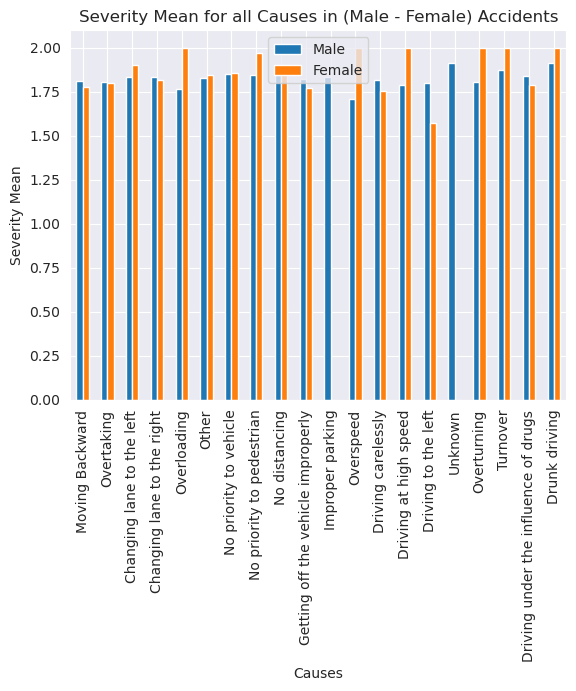

In [30]:
dataMF = {
    "Male":accident_data.where(accident_data["Sex_of_driver"] == "Male").groupby(['Cause_of_accident'])['Accident_severity'].mean() ,
    "Female":accident_data.where(accident_data["Sex_of_driver"] == "Female").groupby(['Cause_of_accident'])['Accident_severity'].mean()
    }
plotdata = pd.DataFrame(dataMF ,
    index= accident_data['Cause_of_accident'].unique()
)
plotdata.plot(kind="bar")
plt.title("Severity Mean for all Causes in (Male - Female) Accidents")
plt.xlabel("Causes")
plt.ylabel("Severity Mean")

# Hypothesis 2: Is Speeding is the main Cause for Car Crashes?
### Graph: Graphical Representation to Probability of Each Cause to Happen
For all causes: P(Cause_i)

####  As Shown
##### The Graph here shows that it's not right that Speed is one of the main reasons that causes an accident as it appears at the tail of the graph 

Text(0.5, 0, 'Causes')

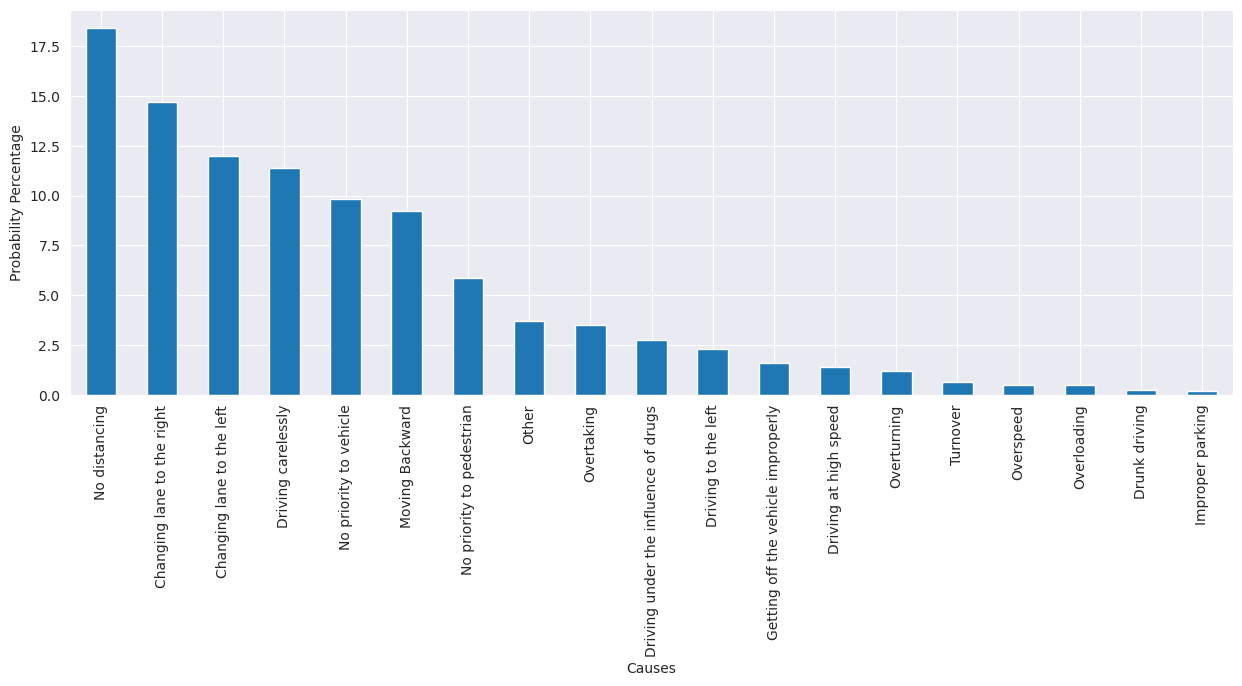

In [33]:
plt.figure(figsize =(15,5))
a= accident_data.loc[accident_data['Cause_of_accident'] !="Unknown"]
bar_plot=((a.groupby('Cause_of_accident')['Cause_of_accident'].count().sort_values(ascending=False)/a['Cause_of_accident'].count())*100).plot.bar()
bar_plot.set_ylabel("Probability Percentage")
bar_plot.set_xlabel("Causes")

### Here we can see speed contribute comparatively less in accident. The top 4 main causes for accident:
* No Distancing
* Chaning lane to the right
* Changing lane to the left 
* Driving carelessly